# From Raw Data to Resolved Identities: Transforming Your Data for Senzing Entity Resolution
## Step-by-Step Strategies to Prepare Your Data for Accurate, Scalable Identity Matching
#### Written by: Clair J. Sullivan (clair@clairsullivan.com)
#### January 23, 2025

## Introduction

Entity resolution is all about untangling messy data to match records that refer to the same real-world entity, like spotting duplicates of a customer with slightly different names or addresses.  It’s the secret sauce for fixing data quality issues, linking information across datasets, and getting a clear, 360-degree view of your customers.  Senzing is a plug-and-play AI solution designed to make entity resolution fast, easy, and scalable.  It works in real-time to uncover connections in your data, giving you a clear view of every record linked to a person, company, or a multitude of other entity types through the use of a simple SDK-like interface.

In my [previous blog post](https://senzing.com/knowledge-graphs-graph-rag/) I showed the importance of doing entity resolution to create entity-resolved knowledge graphs (ERKGs).  It was based on the [introduction to ERKGs](https://senzing.com/entity-resolved-knowledge-graphs/) by Paco Nathan.  While these two posts showed the importance of using entity resolution in creating knowledge graphs, they only briefly demonstrated how one maps real world data into Senzing for entity resolution.  In this post, I will show with real-world data how one would take a CSV file in Python and generate files that can be read and analyzed by Senzing.

As usual, all data and code used in this blog post can be found on my [GitHub profile](https://github.com/cj2001/senzing_occrp_mapping_demo).

## Overview of the OCCRP data

The [Organized Crime and Corruption Reporting Project (OCCRP)](https://www.occrp.org/en) is an investigative journalism organization dedicated to providing information, infrastructure, tooling, and resources to those looking to report on crime and corruption.  This includes providing access to a great deal of data sourced from over 4 billion documents to help journalists and activists uncover key facts about people, companies, and financial transactions.

One such dataset contains financial transactions dubbed the [Azerbaijani Laundromat](https://www.occrp.org/en/project/the-azerbaijani-laundromat).  From 2012 to 2014, Azerbaijan’s ruling elite orchestrated a $2.9 billion money laundering scheme to conceal the origins of vast sums of money to finance personal luxuries, political influence, and public relations campaigns.  Banking records revealed that funds were funneled through [four UK-registered shell companies](https://www.occrp.org/en/project/the-azerbaijani-laundromat/the-core-companies) with lax oversight and processed by Danske Bank’s Estonian branch, which failed to investigate suspicious transactions.  The money flowed to secretive offshore entities, luxury car dealerships, football clubs, and high-profile individuals, including European politicians and Azerbaijani officials, often disguising its problematic origins.  The full extent of this complex laundering operation remains unclear, highlighting systemic vulnerabilities in global financial systems.  This data has been provided by OCCRP as a [downloadable database](https://www.occrp.org/en/project/the-azerbaijani-laundromat/the-raw-data) of nearly 17,000 payments made to and from the four core UK-registered companies that made up the Azerbaijani Laundromat.  Given its structure and importance, this dataset makes for an interesting demonstration for how to bring data from Python into Senzing.  Additionally, given its size it can be processed using the free tier of Senzing.

For this demonstration we will be using [Google Colab](https://colab.research.google.com/), which gives you free access to a notebook environment that can be configured to use any of a number of different runtime engines, including the option to use a free GPU (not needed for this blog post).  Additionally, it can be linked to your Google Drive to allow for access to your files stored there.

We will begin by creating a folder in our Google Drive (I called mine `Senzing` and then created a subfolder in that folder called data).  I created a notebook within the main Senzing directory and stored the data file (`occrp_17k.csv`) within the data subfolder.  Once those directories and the data file are in place, you can then connect to it (after necessary imports) via:

In [1]:
import json
import hashlib
import numpy as np
import os
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Senzing/data')

Mounted at /content/drive


Now we can load our data in.  We find that there are not too many null values:

In [3]:
df = pd.read_csv('occrp_17k.csv', dtype=str)
null_counts = df.isnull().sum()
print(null_counts)

payer_name                    0
payer_jurisdiction            0
payer_account               115
source_file                   0
amount_orig                   0
id                            0
beneficiary_type              0
beneficiary_core              0
amount_orig_currency          0
beneficiary_name              0
beneficiary_jurisdiction      0
investigation                 0
beneficiary_bank_country      4
beneficiary_name_norm         0
payer_core                    0
beneficiary_account           4
purpose                       0
date                          0
amount_usd                    0
amount_eur                    0
payer_type                    0
payer_name_norm               0
payer_bank_country          115
dtype: int64


Therefore I chose to just do some light cleaning.  Then we can get a feel for what the data looks like.

In [4]:
df.replace(['NA', 'NULL', 'NUL', 'null'], np.nan, inplace=True)
df.fillna(value='UNKNOWN', inplace=True)
df.head()

,payer_name,payer_jurisdiction,payer_account,source_file,amount_orig,id,beneficiary_type,beneficiary_core,amount_orig_currency,beneficiary_name,beneficiary_jurisdiction,investigation,beneficiary_bank_country,beneficiary_name_norm,payer_core,beneficiary_account,purpose,date,amount_usd,amount_eur,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,pdf/LCM ALLIANCE Account statement 30.06.12-31...,535470.0,6049,Company,True,USD,LCM ALLIANCE LLP,GB,az,EE,LCM ALLIANCE LLP,False,EE27 3300 3335 0561 0002,1206295100052180 OCT4121800021 ADVANCE PAYM FO...,2012-06-30,535470,"$431,762.31",Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,pdf/LCM ALLIANCE Account statement 30.06.12-31...,-535000.0,6050,Company,False,USD,MOBILA LLP,GB,az,33,MOBILA LLP,True,333504500003,1207035026699176 INVOICE.No 6215 DD 25.05.2012,2012-07-03,535000,"$423,688.44",Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,pdf/METASTAR Account statement 30.06.12-31.12....,90535.19,10623,Company,True,USD,METASTAR INVEST LLP,GB,az,EE,METASTAR INVEST LLP,False,EE77 3300 3334 8704 0004,"1207065103089249 /FEE/USD4,81",2012-07-06,90536,"$71,698.53",Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-90520.0,15589,Company,False,USD,INMAXO CAPITAL CORP,VG,az,33,INMAXO CAPITAL CORP.,True,333455870002,1207095022358525 DOGOVOR ZAYMA,2012-07-09,90520,"$71,686.50",Company,METASTAR INVEST LLP,EE
4,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-60.0,10624,Company,False,USD,INMAXO CAPITAL CORP,VG,az,33,INMAXO CAPITAL CORP.,True,333455870002,1207135024578077 DOGOVOR ZAYMA,2012-07-13,60,$47.52,Company,METASTAR INVEST LLP,EE


In [6]:
df.shape

(16940, 23)

In [7]:
df.columns

Index(['payer_name', 'payer_jurisdiction', 'payer_account', 'source_file',
       'amount_orig', 'id', 'beneficiary_type', 'beneficiary_core',
       'amount_orig_currency', 'beneficiary_name', 'beneficiary_jurisdiction',
       'investigation', 'beneficiary_bank_country', 'beneficiary_name_norm',
       'payer_core', 'beneficiary_account', 'purpose', 'date', 'amount_usd',
       'amount_eur', 'payer_type', 'payer_name_norm', 'payer_bank_country'],
      dtype='object')

In this file there are 16,940 rows and 23 columns corresponding to individual transactions (rows) between payers and beneficiaries.  The data set includes their names, jurisdictions, banks, account numbers, payment amounts in a variety of different currencies, alleged purpose of the payment, and dates of the payments.  We also see that there are different entity types associated with the payers and beneficiaries.  Utilizing the following we can see that the payers and beneficiaries can be of one of three different types:

In [8]:
print(df['payer_type'].unique())
print(df['beneficiary_type'].unique())

['Company' 'Invalid' 'Person']
['Company' 'Person' 'Invalid']


Given what we know about this dataset, we expect to see some entities appear several times, namely the four core UK companies.  So we know that we have an ER problem, but we do not yet know the extent of it.

## Reading data in, writing data out

Now that we know a little something about the dataset, we need to get it into a format that Senzing can automatically read it in.  For the purposes of this demonstration we will be using the Senzing API for doing the ER.  The general idea is that we need to take this dataframe and map the columns and their values to things that Senzing will recognize.  I cannot recommend strongly enough that the easiest way to understand and do this is by reading the [Senzing Generic Entity Specification](https://senzing.zendesk.com/hc/en-us/article_attachments/30709424434963).  What this document does is tell you all of the possible values that Senzing recognizes for data along with required, desired, and optional values.  For example, each entity has a record key (see page 8\) that is required to have a `DATA_SOURCE`, while it is strongly recommended that they have a `RECORD_ID` along with a `RECORD_TYPE`.  In the case of the OCCRP data, we will break the data into payers and beneficiaries for the `DATA_SOURCE` while using `payer_type` and `beneficiary_type` as our `RECORD_TYPE` (i.e. `RECORD_TYPE` will be either `COMPANY, PERSON`, or `INVALID`).  While we are at it, we are also going to drop any complete duplicates that exist in the data:


In [9]:
payer_columns = [col for col in df.columns if col.startswith('payer')]
beneficiary_columns = [col for col in df.columns if col.startswith('beneficiary')]

# Create payer DataFrames with only payer columns
payer_companies = df[df['payer_type'] == 'Company'][payer_columns].drop_duplicates()
payer_persons = df[df['payer_type'] == 'Person'][payer_columns].drop_duplicates()
payer_invalids = df[df['payer_type'] == 'Invalid'][payer_columns].drop_duplicates()

# Create beneficiary DataFrames with only beneficiary columns
beneficiary_companies = df[df['beneficiary_type'] == 'Company'][beneficiary_columns].drop_duplicates()
beneficiary_persons = df[df['beneficiary_type'] == 'Person'][beneficiary_columns].drop_duplicates()
beneficiary_invalids = df[df['beneficiary_type'] == 'Invalid'][beneficiary_columns].drop_duplicates()

payer_companies.shape, payer_persons.shape, payer_invalids.shape, beneficiary_companies.shape, beneficiary_persons.shape, beneficiary_invalids.shape

((442, 7), (10, 7), (22, 7), (3361, 7), (429, 7), (3, 7))

In [10]:
payer_companies.head()

,payer_name,payer_jurisdiction,payer_account,payer_core,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,False,Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,True,Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,False,Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,True,Company,METASTAR INVEST LLP,EE
5,INMAXO CAPITAL CORP.,VG,333455870002,False,Company,INMAXO CAPITAL CORP.,33


In [11]:
beneficiary_companies.head()

,beneficiary_type,beneficiary_core,beneficiary_name,beneficiary_jurisdiction,beneficiary_bank_country,beneficiary_name_norm,beneficiary_account
0,Company,True,LCM ALLIANCE LLP,GB,EE,LCM ALLIANCE LLP,EE27 3300 3335 0561 0002
1,Company,False,MOBILA LLP,GB,33,MOBILA LLP,333504500003
2,Company,True,METASTAR INVEST LLP,GB,EE,METASTAR INVEST LLP,EE77 3300 3334 8704 0004
3,Company,False,INMAXO CAPITAL CORP,VG,33,INMAXO CAPITAL CORP.,333455870002
7,Company,False,JETFIELD NETWORKS LIMITED,NZ,33,JETFIELD NETWORKS LIMITED,333488110001


Next, we have the opportunity to specify some record attributes (pages 9-14).  I have chosen to use the dataframe to populate `NAME_ORG, ADDR_COUNTRY, ACCOUNT_NUMBER,` and `ACCOUNT_DOMAIN`.

In order to map the dataframe columns to the Senzing attribute names, we create the following mappers:

In [12]:
payer_mapping = {
    'DATA_SOURCE': 'PAYERS',
    'RECORD_ID': 'payer_record_id',
    'RECORD_TYPE': None,  # To be set based on the DataFrame (COMPANY, PERSON, INVALID)
    'NAME_ORG': 'payer_name',
    'ADDR_COUNTRY': 'payer_jurisdiction',
    'ACCOUNT_NUMBER': 'payer_account',
    'ACCOUNT_DOMAIN': 'payer_bank_country'
}

beneficiary_mapping = {
    'DATA_SOURCE': 'BENEFICIARIES',
    'RECORD_ID': 'beneficiary_record_id',
    'RECORD_TYPE': None,  # To be set based on the DataFrame (COMPANY, PERSON, INVALID)
    'NAME_ORG': 'beneficiary_name',
    'ADDR_COUNTRY': 'beneficiary_jurisdiction',
    'ACCOUNT_NUMBER': 'beneficiary_account',
    'ACCOUNT_DOMAIN': 'beneficiary_bank_country'
}

Next, we have to actually do the mapping and get the data into a format that Senzing can read.  The API is capable of reading either JSON or CSV.  However, the JSON is more flexible since it can take lists for values and therefore I decided to go this route.  I created the following function then to map the Pandas dataframe to JSON format with the `payer_mapping` and `beneficiary_mapping` dictionaries:

In [13]:
def generate_json(df, mapping, record_type):
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()

    # Set constant values
    df_copy['DATA_SOURCE'] = mapping['DATA_SOURCE']
    df_copy['RECORD_TYPE'] = record_type.upper()  # Ensure RECORD_TYPE is uppercase

    # Rename columns according to the mapping
    df_copy.rename(columns={
        mapping['NAME_ORG']: 'NAME_ORG',
        mapping['ADDR_COUNTRY']: 'ADDR_COUNTRY',
        mapping['ACCOUNT_NUMBER']: 'ACCOUNT_NUMBER',
        mapping['ACCOUNT_DOMAIN']: 'ACCOUNT_DOMAIN'
    }, inplace=True)

    # Select the required columns and create another copy to ensure no warnings
    columns_order = ['DATA_SOURCE', 'RECORD_TYPE', 'NAME_ORG',
                     'ADDR_COUNTRY', 'ACCOUNT_NUMBER', 'ACCOUNT_DOMAIN']
    df_json = df_copy[columns_order].copy()  # Explicitly copy the selected DataFrame

    # Ensure all columns are strings to prevent numeric conversion
    for col in columns_order:
        df_json[col] = df_json[col].astype(str)

    # Create the RECORD_ID column by hashing the concatenated values of the columns
    def generate_record_id(row):
        # Concatenate all values in the row into a single string
        concatenated_values = ''.join(row[col] for col in columns_order)
        # Generate the MD5 hash
        return hashlib.md5(concatenated_values.encode('utf-8')).hexdigest()

    # Apply the function to generate RECORD_ID for each row
    df_json['RECORD_ID'] = df_json.apply(generate_record_id, axis=1)

    # Convert DataFrame to JSON records
    records = df_json.to_dict(orient='records')

    return records


One key thing this function does beyond just mapping dataframe columns to Senzing attribute names is the creation of the `RECORD_ID`.  In this case, it creates an md5 hash based on the concatenation of the six column values for each record (`DATA_SOURCE, RECORD_TYPE, NAME_ORG, ADDR_COUNTRY, ACCOUNT_NUMBER, ACCOUNT_DOMAIN`).  The result is that the `RECORD_ID` is unique (this can easily be confirmed by running the following two commands from the command line on the JSON files that will be created):
```
sort *.json | uniq -c | awk '$1 > 1' > duplicates.txt

awk '$1 > 1 {sum += ($1 - 1)} END {print "Total non-unique RECORD_IDs:", sum}' duplicates.txt
```

Assuming all has gone well, the above should give you:

```
Total non-unique RECORD_IDs:
```

(i.e. it didn't find any non-unique IDs.)

We now can run this function on the six combinations representing payers and beneficiaries that are companies, people, and invalids.  Doing so for payers looks like this:

In [14]:
payer_companies_json = generate_json(payer_companies, payer_mapping, record_type='COMPANY')
payer_persons_json = generate_json(payer_persons, payer_mapping, record_type='PERSON')
payer_invalids_json = generate_json(payer_invalids, payer_mapping, record_type='INVALID')

We can inspect one of these entries to make sure it matches the our expectations:

In [15]:
payer_companies_json[0]

{'DATA_SOURCE': 'PAYERS',
 'RECORD_TYPE': 'COMPANY',
 'NAME_ORG': 'AZARBAYCAN METANOL KOMPANI MMC',
 'ADDR_COUNTRY': 'AZ',
 'ACCOUNT_NUMBER': '33817018409333311204',
 'ACCOUNT_DOMAIN': '33',
 'RECORD_ID': '991649265e1a7bd9a5fc4d174e8a4cd7'}

Great!  We now save these dictionaries to JSON files:

In [16]:
with open('payer_companies.json', 'w') as f:
    for record in payer_companies_json:
        json.dump(record, f)
        f.write('\n')  # Write each record on a new line

with open('payer_persons.json', 'w') as f:
    for record in payer_persons_json:
        json.dump(record, f)
        f.write('\n')

with open('payer_invalids.json', 'w') as f:
    for record in payer_invalids_json:
        json.dump(record, f)
        f.write('\n')

We now run this similarly for the beneficiaries:

In [17]:
beneficiary_companies_json = generate_json(beneficiary_companies, beneficiary_mapping, record_type='COMPANY')
beneficiary_persons_json = generate_json(beneficiary_persons, beneficiary_mapping, record_type='PERSON')
beneficiary_invalids_json = generate_json(beneficiary_invalids, beneficiary_mapping, record_type='INVALID')

In [18]:
beneficiary_companies_json[0]

{'DATA_SOURCE': 'BENEFICIARIES',
 'RECORD_TYPE': 'COMPANY',
 'NAME_ORG': 'LCM ALLIANCE LLP',
 'ADDR_COUNTRY': 'GB',
 'ACCOUNT_NUMBER': 'EE27 3300 3335 0561 0002',
 'ACCOUNT_DOMAIN': 'EE',
 'RECORD_ID': 'c56afa69f8e535cfa43c99c74bb7fc82'}

In [19]:
with open('beneficiary_companies.json', 'w') as f:
    for record in beneficiary_companies_json:
        json.dump(record, f)
        f.write('\n')

with open('beneficiary_persons.json', 'w') as f:
    for record in beneficiary_persons_json:
        json.dump(record, f)
        f.write('\n')

with open('beneficiary_invalids.json', 'w') as f:
    for record in beneficiary_invalids_json:
        json.dump(record, f)
        f.write('\n')

## Getting the data into Senzing

At this point, we now have six JSON files.  A simple line count gives us an idea of how much data we actually have at this point:

```
$ wc -l *.json  
   3361 beneficiary_companies.json  
      3 beneficiary_invalids.json  
    429 beneficiary_persons.json  
    442 payer_companies.json  
     22 payer_invalids.json  
     10 payer_persons.json  
   4267 total
```

Interesting\!  So we have gone from almost 17k rows of data where each row had both a payer and a beneficiary (meaning we could have doubled our total data to around 34k entities) to 4267 entities.  This is largely because the four key UK companies under investigation were at the heart of most of these transactions.  However, it is helpful nonetheless to get rid of these duplicates to get at the heart of how many entities are really involved in this laundromat.  (As you will see, we will be able to do much better once we plug this into Senzing\!)  But here is a key point: **if you can’t resolve your entities, you can’t count.**  Being able to get accurate counts of your data is one of the most fundamental measurements and yet without entity resolution you are almost guaranteed to do it wrong\!

So our next step is to load this data into Senzing.  I am using a Linux machine to do this and there is a great [Quickstart for Linux](https://senzing.zendesk.com/hc/en-us/articles/115002408867-Quickstart-for-Linux) that walks you through how to do it.  But I want to show how to do it specifically for this data.

If you don’t already have Senzing installed, the instructions for how to do so can be found at the top of the Quickstart for Debian- and Red Hat-based distributions.  I will note that I am using Pop\!\_OS, which is Debian-based, but had a bit of trouble installing `senzingrepo_2.0.0-1_all.deb` as used in the Quickstart.  However, I found that [`https://senzing-production-apt.s3.us-east-1.amazonaws.com/senzingrepo_2.0.1-1_all.deb`](https://senzing-production-apt.s3.us-east-1.amazonaws.com/senzingrepo_2.0.1-1_all.deb) worked just fine for me.

Once you get Senzing installed, we need to create a Senzing project.  To do that, I did

```
python3 /opt/senzing/g2/python/G2CreateProject.py ~/senzing_occrp
```

After that completes, you can go into that directory and run

```
source setupEnv
```

which sets up certain environment variables for you.  Next, just for the sake of my own organization, I created a subdirectory in `~/senzing_occrp` called `occrp_data`.  I then moved the six JSON files to that subdirectory.  

After that is complete, you are ready to configure Senzing to handle those JSON files.  To do this, from within the `senzing_occrp` directory you will run  

```
./python/G2ConfigTool.py
```

What this is going to do is configure the backend database Senzing is working with to handle the data that it will load.  In this case, we need to tell Senzing what the possible values are for `DATA_SOURCE`.  To do this, you will do the following:

```
addDataSource PAYERS  
addDataSource BENEFICIARIES  
save  
exit
```

Cool\!  Now we are ready to actually load in the data and do the entity resolution\!  By the time we get to this point, it is almost anticlimatic.  All you have to do is run the following command:

```
./python/G2Loader.py -f ./occrp_data/beneficiary_companies.json
```


(Note that you will run this command once for each of the six files.)  This will output many things to the screen, but the last bit will look like this:

```
Processing Information  
----------------------

    Arguments:                       -f ./cj_data/beneficiary_companies.json  
    Action:                          Add  
    Repository purged:               No  
    Source File:                     /home/cj2001/senzing_occrp/occrp_data/beneficiary_companies.json  
    Shuffled into:                   Shuffled file deleted (-snd to keep after load)  
    Total records:                   3,361  
    	Good records:                3,361  
    	Bad records:                 0  
    	Incomplete records:          0  
    Records specifying action:       0  
    	Adds:                        0  
    	Deletes:                     0  
    	Reeval:                      0  
    Errors:`  
    	Errors log file:             No errors  
    	Failed API calls:            0  
    Skipped records:                 Not requested  
    Stop on record:                  Not requested  
    Total elapsed time:              0.2 mins  
    	Start time:                  01:56:41pm  
    	End time:                    01:56:52pm  
    	Time processing redo:        0.0 mins  
    	Time paused in governor(s):  0.0 mins  
    Records per second:              1,121

Process completed successfully at 01:56pm in 0.2 minutes
```

This is exactly what we want to see: no errors.  And you can see that this took under a minute to run.  Fabulous\!  Once you do this for all of the JSON files, you will have completed the loading and entity resolution process.  Now it is time to really start having fun with this data\!

## Exploring the data

The easiest way to explore the results of the ER is through the G2 Exploratory Data Analysis tool.  To start it up you will run  

```
./python/G2Explorer.py
```

Let’s start by just getting a single record:

```
get 1
```

This gets the record for entity 1 in the database:




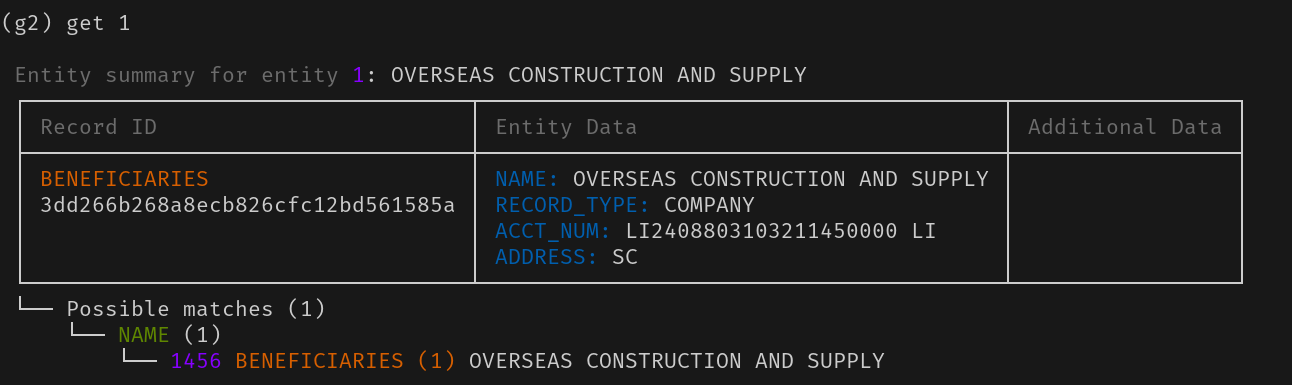

Interesting\!  We just randomly picked a single record and already have a possible entity match\!  Senzing is telling us that they are a match because the name is similar.  Let’s explore that a bit utilizing the `compare` command:

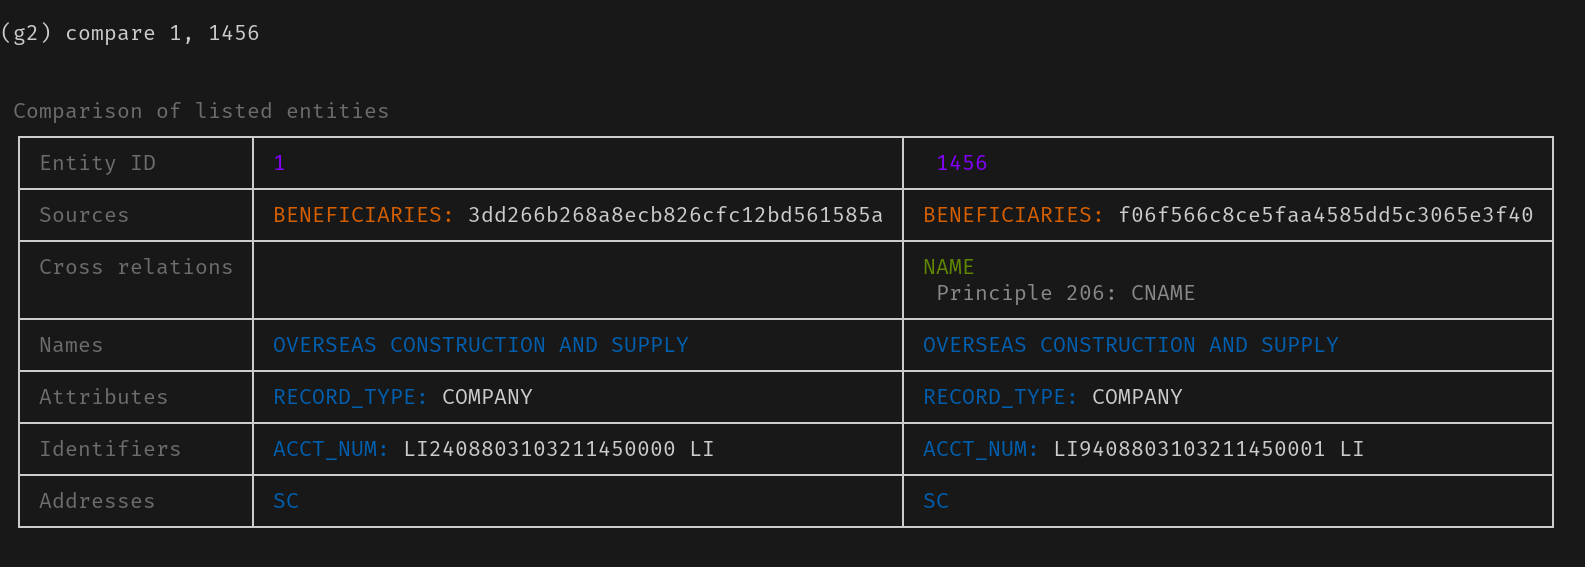